<a href="https://colab.research.google.com/github/hbbell333/Explainable-Deep-Learning/blob/main/AIPI_590_Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Henry Bell

AIPI 590

Explainable Deep Learning

**Chosen image classification problem: Dogs vs Cats**
I chose to work with a pretrained model that classifies images as either "dogs" or "cats". I am preferential to cats, and would always prefer to see a cat rather than a dog if possible.

**All uses of AI are cited in comments**

In [26]:
pip install grad-cam

In [27]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from datasets import load_dataset



In [28]:
#Load dataset & model

dataset = load_dataset("microsoft/cats_vs_dogs")

processor = AutoImageProcessor.from_pretrained("TheBirdLegacy/CatsandDogsPOC-Resnet")
model = ResNetForImageClassification.from_pretrained("TheBirdLegacy/CatsandDogsPOC-Resnet")



In [29]:

# Run model on a small sample to check that it's working

dataset_sample = dataset["train"].shuffle(seed=42).select(range(100))

outputs = []
num_correct = 0

for data_item in dataset_sample:

  inputs = processor(data_item["image"], return_tensors="pt")

  with torch.no_grad():
    logits = model(**inputs).logits

  predicted_label = logits.argmax(-1).item()

  outputs.append((predicted_label, data_item["labels"]))
  if predicted_label == data_item["labels"]:
    num_correct += 1

print(f"Accuracy: {num_correct / len(dataset_sample)}")



Accuracy: 0.89


I've now loaded the pretrained model & dataset, and tested it on 100 samples to ensure that it's working.

**Note that I am using the 'train' split from the dataset.** This is because the dataset has only one split, 'train'. I have confirmed that this dataset is different from the one originally used to train the model.

In [30]:
#Gradcam imports
import torch
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from functools import partial
from PIL import Image
import numpy as np
import cv2



In [31]:
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

def segformer_reshape_transform_huggingface(tensor, width, height):
    result = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result



In [32]:
def generate_grad_cam(image):

  # specify cat as the target to explain
  targets = [ClassifierOutputTarget(0)]

  # wrap the model to output logits directly
  wrapped_model = HuggingfaceToTensorModelWrapper(model)

  # specify a layer to examine (in this case, the last convolutional layer)
  target_layers = [model.resnet.encoder.stages[3].layers[-1]]



  # read test_image as an rgb and convert to float32 and normalize to [0, 1]
    #Gemini used to debug this line, adding normalization [10/2]
  rgb_img = np.asarray(image.convert("RGB")).astype(np.float32) / 255

  input_tensor = processor(image, return_tensors="pt")['pixel_values']


  with GradCAM(model=wrapped_model, target_layers=target_layers) as cam:

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    grayscale_cam = grayscale_cam[0, :]

    # Resize the grayscale CAM to match the original image dimensions
      #Gemini used to debug. Added this resizing code. [10/2]
    grayscale_cam = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    display(Image.fromarray(visualization))

    model_outputs = cam.outputs

In [33]:
def generate_hires_cam(image):

  # specify cat as the target to explain
  targets = [ClassifierOutputTarget(0)]

  # wrap the model to output logits directly
  wrapped_model = HuggingfaceToTensorModelWrapper(model)

  # specify a layer to examine (in this case, the last convolutional layer)
  target_layers = [model.resnet.encoder.stages[3].layers[-1]]



  # read test_image as an rgb and convert to float32 and normalize to [0, 1]
    #Gemini used to debug this line, adding normalization [10/2]
  rgb_img = np.asarray(image.convert("RGB")).astype(np.float32) / 255

  input_tensor = processor(image, return_tensors="pt")['pixel_values']


  with HiResCAM(model=wrapped_model, target_layers=target_layers) as cam:

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    grayscale_cam = grayscale_cam[0, :]

    # Resize the grayscale CAM to match the original image dimensions
      #Gemini used to debug. Added this resizing code. [10/2]
    grayscale_cam = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    display(Image.fromarray(visualization))

    model_outputs = cam.outputs

In [34]:
def generate_ablation_cam(image):

  # specify cat as the target to explain
  targets = [ClassifierOutputTarget(0)]

  # wrap the model to output logits directly
  wrapped_model = HuggingfaceToTensorModelWrapper(model)

  # specify a layer to examine (in this case, the last convolutional layer)
  target_layers = [model.resnet.encoder.stages[3].layers[-1]]



  # read test_image as an rgb and convert to float32 and normalize to [0, 1]
    #Gemini used to debug this line, adding normalization [10/2]
  rgb_img = np.asarray(image.convert("RGB")).astype(np.float32) / 255

  input_tensor = processor(image, return_tensors="pt")['pixel_values']


  with AblationCAM(model=wrapped_model, target_layers=target_layers) as cam:

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    grayscale_cam = grayscale_cam[0, :]

    # Resize the grayscale CAM to match the original image dimensions
      #Gemini used to debug. Added this resizing code. [10/2]
    grayscale_cam = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    display(Image.fromarray(visualization))

    model_outputs = cam.outputs

**Generate normal grad cam explanations for class = cat**

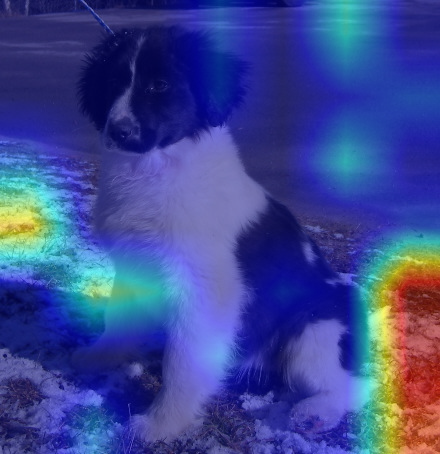

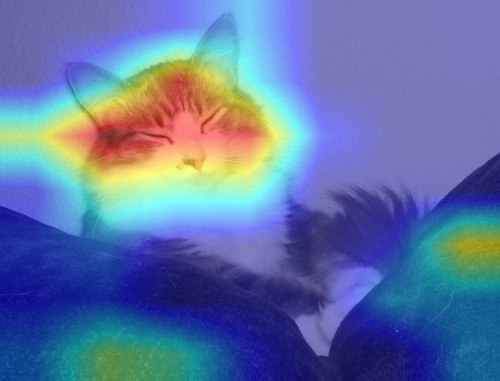

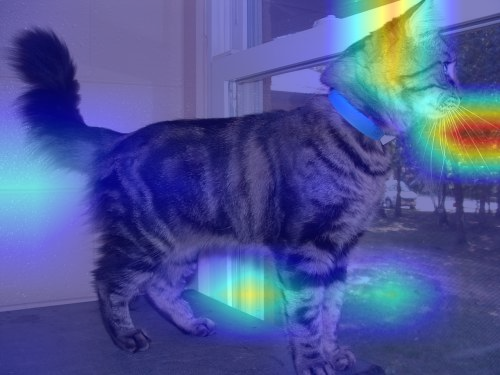

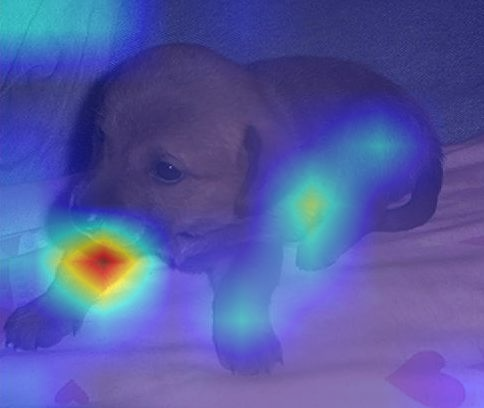

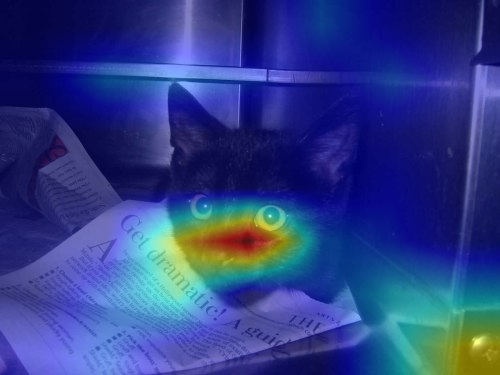

In [35]:
examination_sample = dataset_sample.shuffle(seed=42).select(range(5))

for data_item in examination_sample:
  image = data_item["image"]
  generate_grad_cam(image)

**GradCam Analysis**

For the three sample images of cats, the gradcam explanations mostly align with human expectation. The attention maps focus mostly on defining features of a cat such as the face, whiskers and ears.

The results are a little harder to interpret for the images of dogs. In the first image, the attention map focuses very strongly on a patch of leaves to the right of the dog, and very little on the dog itself. This could be seen as a good thing, since we would want the model to not use dog features to predict the cat class.

In the second dog image however, the attention map focused most on the dog's mouth, paws, and leg. This could be a red flag, since ideally we wouldn't want dog features to activate the cat prediction. If we found that the model was lacking in accuracy, we might chose to disrupt these features during the training process to discourage learning features that apply to both cats and dogs.

If I had to guess, I would expect that training a model specifically to classify cats vs dogs from the start (rather than adapting pretrained resnet50, which is what this model does) would implicitly discourage learning shared features, as they wouldn't be predictive.



**Generate HiresCam explanations for class = cat**

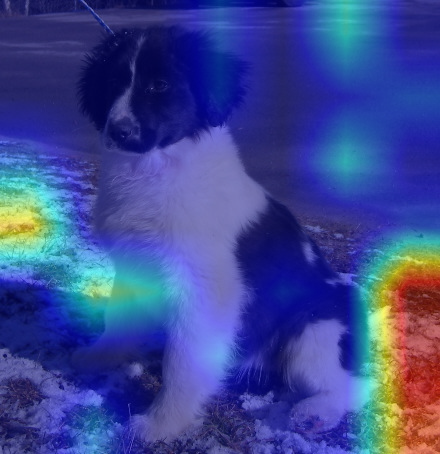

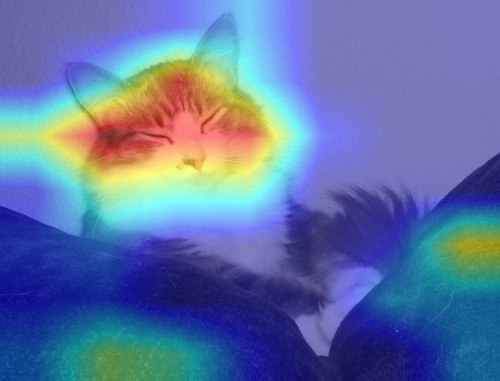

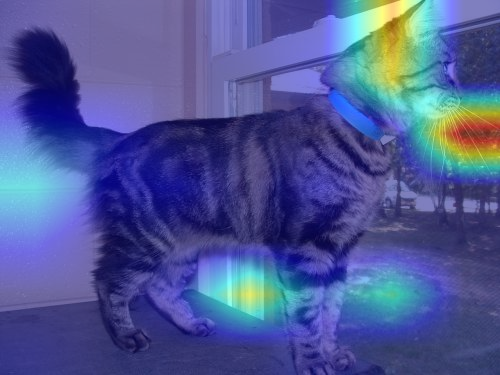

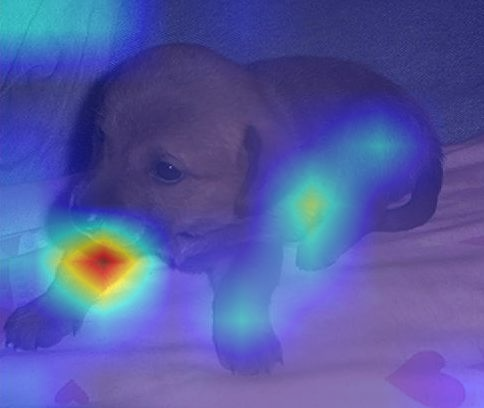

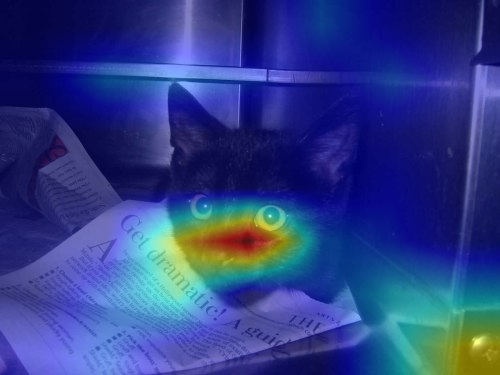

In [36]:
examination_sample = dataset_sample.shuffle(seed=42).select(range(5))

for data_item in examination_sample:
  image = data_item["image"]
  generate_hires_cam(image)

**HiresCam Analysis**

The HiresCam explanations are very similar to the GradCam for each image. This isn't necessarily surprising, since these two methods are very similar in theory. However since HiresCam has more provable guarantees of faithfulness, we should be more confident in the conclusions made previously based on the GradCam attention maps.

**Generate AblationCam Explanations**

100%|██████████| 64/64 [09:39<00:00,  9.05s/it]


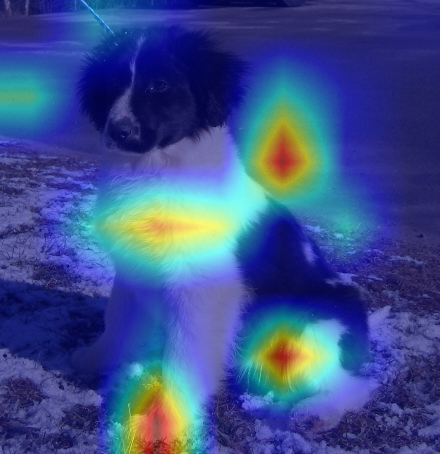

100%|██████████| 64/64 [09:41<00:00,  9.09s/it]


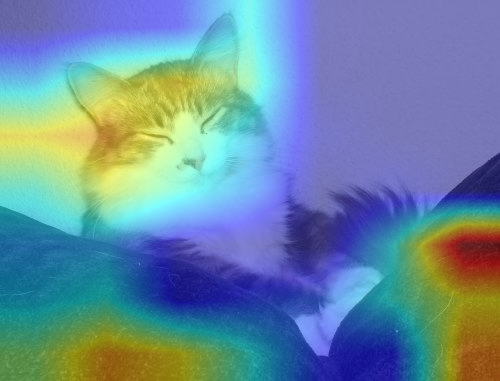

100%|██████████| 64/64 [09:55<00:00,  9.30s/it]


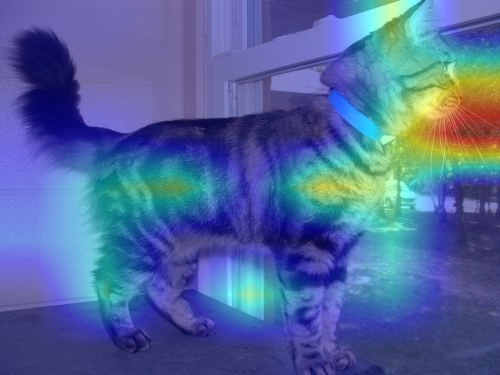

100%|██████████| 64/64 [09:44<00:00,  9.13s/it]


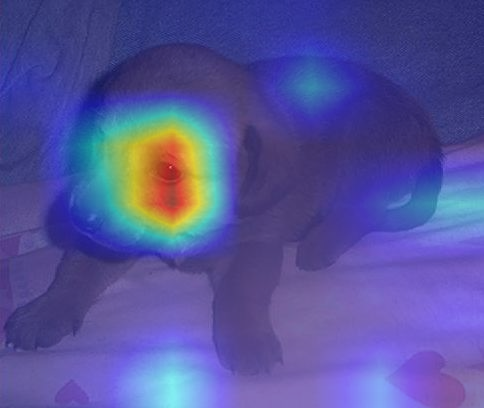

100%|██████████| 64/64 [09:47<00:00,  9.18s/it]


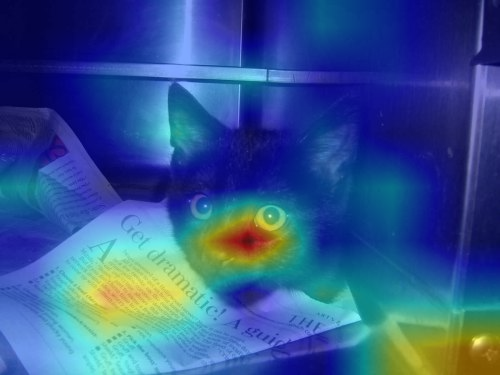

In [37]:
examination_sample = dataset_sample.shuffle(seed=42).select(range(5))

for data_item in examination_sample:
  image = data_item["image"]
  generate_ablation_cam(image)

**AblationCam Analysis**

Interestingly, in the AblationCam explanations the cat image attention maps are very similar to those generated by GradCam and HiresCam but the dog image attention maps differ more significantly from the previous methods.

My instinct is that this is a good sign for the model. We would hope that the cat explanations are stable, because that would suggest that they are founded in real features that the cat images actually have (as opposed to noise). Similarly, the dog explanations being more unstable suggests to me that the features being used in these misclassifications examples are more noisey, and less grounded in real patterns in the dog images.


**Reflection**

At a high level, it seems that the model is attending to relatively appropriate visual cues, such as cat faces, whiskers, paws, and ears.

I was a little surprised to see that when trying to classify a dog image into the cat class, the attention maps still focused on some of the dog's features such as face, paws, or legs. I would expect that any part of the dog would actually decrease the probability of the cat class, however it appears that sometimes the model has trouble discerning between these features. This isn't necessarily a problem (as the model does reach almost 90% accuracy), however it could be useful in informing efforts to improve model performance. As mentioned above, I suspect this behavior is in part due to the representation learned by resnet-50, which this model uses as a pre-trained base. Since resnet-50's objective is to classify many different things, it could be fine for cat and dog faces to be close in the representation space. However, a model that's only objective is to differentiate between cats and dogs would, I expect, encode these features as more distinct.

This domain is admittadly a little silly, however I think explainability still plays an important role. As explained above, the model *is* conflating some of the features between the dog and cat class. If the model was performing poorly (or if you wanted to improve already good performance), it could be valuable to use explainability tools to better understand the flaws first.

While it's practically feasible to improve model performance without understanding the underlying problem, via things like ablations & hyperparameter tuning, identifying key failure points can focus the iterative improvement process considerably, saving time & money.
